In [17]:
import pandas as pd
import os
import json
from collections import Counter
import re
import numpy as np

## Joining Final Annotations and Unmatched Annotations 

In [18]:
PATH_DATA = '../data/'
PATH_DF = '../data/dataframes/'
PATH_FINAL = '../data/final/'

In [19]:
annotations = {}

for file in os.listdir(PATH_DF):
    if file.startswith('annotation') and file.endswith('.tsv'):
        annotator = file.split('_')[-1].split('.')[0]
        annotations[annotator] = pd.read_csv(PATH_DF + file, sep='\t')

all_annotations_df = pd.concat(annotations, ignore_index=True)
all_annotations_df = all_annotations_df.drop_duplicates(ignore_index=True)

In [20]:
final_annotations_df = pd.DataFrame()
interannotated_courses = set()

for file in os.listdir(PATH_FINAL):
    if file.endswith('.tsv'):
        fn = PATH_FINAL + '/' + file
        with open(fn, 'r') as f:
            size = len(f.readlines())
            if size > 0:
                incoming_df = pd.read_csv(fn, delimiter='\t')
                incoming_df = incoming_df.fillna("")
                
                course_number = file.split(".")[0]
                incoming_df["course"] = int(course_number)
                interannotated_courses.add(int(course_number))

                final_annotations_df = pd.concat([final_annotations_df, incoming_df], ignore_index=True)

final_annotations_df = final_annotations_df.drop_duplicates(ignore_index=True)
final_annotations_df = final_annotations_df.drop(columns=['_merge'])

In [21]:
matched_courses = final_annotations_df.course.unique()

In [22]:
unmatched_annotations_df = all_annotations_df[~all_annotations_df.course.isin(interannotated_courses)].reset_index(drop=True)


In [23]:
unmatched_courses = unmatched_annotations_df.course.unique()

In [24]:
product_df = pd.concat([final_annotations_df, unmatched_annotations_df], ignore_index=True)
product_df = product_df.fillna("")
product_df = product_df.drop(columns='collection')
product_df = product_df.drop_duplicates().reset_index(drop=True)

In [25]:
Counter(list(product_df.drop(columns='course').value_counts()))

Counter({3: 6, 2: 83, 1: 8228})

In [26]:
product_df.to_csv('database.tsv', sep='\t', index=False)

In [27]:
# Should maintain index from here 

In [28]:
len(unmatched_courses)

109

In [29]:
len(interannotated_courses)

226

## Data Cleaning/Processing

In [30]:
def simplify_type(t):
    if t == 'article-journal':
        return "Academic Paper"
    elif t in ['book', 'chapter']:
        return "Book"
    else:
        return "Other"

In [31]:
product_df['type'] = product_df.type.apply(simplify_type)

In [32]:
product_df['year'] = product_df.year.apply(lambda x: str(x).split('-')[0][:4])

In [33]:
def parse_author_name(s):
    if type(s)==float:
        return "" 
    last_name = re.match('.*:family=>"([a-zA-Z]*)"', s)
    if last_name:
        last_name = last_name.group(1)
    else:
        return ""

    first_initial = re.match('.*:given=>"([a-zA-Z\.\s]*)"', s)
    if first_initial:
        first_initial = first_initial.group(1)[0]
        return last_name + ", " + first_initial + "."
    else:
        return last_name


def convert_str_to_list_author(s, return_format):
    """Converts string representation of list into list"""
    authors = re.findall('\{[^\{]*\}', s.strip('[]'))
    parsed_authors = [parse_author_name(a) for a in authors if parse_author_name(a)!='']
    if return_format:
       return '; '.join(parsed_authors)
    return parsed_authors

In [34]:
product_df['author_individual'] = product_df.author.apply(convert_str_to_list_author, return_format='')
product_df['author'] = product_df.author.apply(convert_str_to_list_author, return_format='joined')
product_df.explode('author')

,author,title,type,year,category,course,author_individual
0,"Ott, E.; Sauer, T.; Yorke, J.",Coping with Chaos,Other,1994,Optional,1022,"[Ott, E., Sauer, T., Yorke, J.]"
1,"Wilks, D.",Statistical Methods in the Atmospheric Sciences,Other,1995,Optional,1022,"[Wilks, D.]"
2,"Wunsch, C.",The Ocean Circulation Inverse Problem,Other,1996,Optional,1022,"[Wunsch, C.]"
3,"Kalnay, E.",Atmospheric Modeling,Other,2003,Optional,1022,"[Kalnay, E.]"
4,"Grassberger, P.; Procaccia, I.",Characterization of Strange Attractors,Academic Paper,1983,Required,1022,"[Grassberger, P., Procaccia, I.]"
...,...,...,...,...,...,...,...
8407,"Gesteland, R.",Cross-Cultural Business Behavior: Marketing,Other,1999,Required,1248,"[Gesteland, R.]"
8408,"Kouzes, J.; Posner, B.",The Leadership Challenge,Other,2002,Required,1248,"[Kouzes, J., Posner, B.]"
8409,"Goleman, D.",Leadership that Gets Results,Academic Paper,2000,Required,1248,"[Goleman, D.]"
8410,"Derr, C.; Roussillon, S.; Bournois, F.",Cross-Cultural Approaches to Leadership Develo...,Other,2002,Required,1248,"[Derr, C., Roussillon, S., Bournois, F.]"


In [35]:
# Load index-link mappings
with open(PATH_DATA + 'all_topics.json', encoding='utf-8') as f:
    topics = json.load(f)

annotated_topics = {course: topics for course, topics in topics.items() if int(course) in product_df.course.values}

In [36]:
topic_counter = Counter([t for topics in annotated_topics.values() for t in topics])

In [37]:
product_df['topics'] = product_df['course'].apply(lambda x: annotated_topics[str(x)])
product_df = product_df.explode('topics')

In [38]:
product_df[product_df.topics=='Mathematics'].groupby('category').count()/topic_counter['Mathematics']

,author,title,type,year,course,author_individual,topics
category,,,,,,,
Optional,6.844444,6.844444,6.844444,6.844444,6.844444,6.844444,6.844444
Required,6.711111,6.711111,6.711111,6.711111,6.711111,6.711111,6.711111


In [39]:
# Load index-link mappings
f = open(PATH_DATA + 'index_to_link.json', encoding='utf-8') 
index_to_link = json.load(f)
f.close()

In [40]:
product_df = product_df[product_df.author!=""]
product_df = product_df[product_df.title!=""]

In [41]:
product_df.to_csv('database.tsv', sep='\t', index=False)

In [42]:
def search_readings(TOPIC='Mathematics', FORMAT='All', INCLUDE='All'):
    # Topic selection (Mandatory)
    selection = product_df[product_df.topics==TOPIC].copy()

    # Format selection (if specified)
    if FORMAT in ['Book', 'Academic Paper']:
        selection = selection[selection.type == FORMAT]

    # Include categories (if specified)
    if INCLUDE == 'Required Only':
        selection = selection[selection.category == 'Required']
    elif INCLUDE == 'Optional Only':
        selection = selection[selection.category == 'Optional']

    num_courses = len(selection.course.unique())
    num_readings = selection.shape[0]

    title_df = selection.copy()
    title_df = title_df.sort_values('title') 
    title_df['Link to Course'] = title_df.course.apply(lambda x: index_to_link[str(x)])
    title_df = title_df.drop(columns=['type', 'author_individual', 'course', 'topics'])
    title_df = pd.DataFrame(title_df.value_counts()).reset_index()
    title_df = title_df.drop(columns=['category', 0])

    author_df = selection.copy()
    author_df = author_df.drop(columns=['author', 'topics'])
    author_df = author_df.explode('author_individual')

    author_df = pd.DataFrame(author_df.author_individual.value_counts()).reset_index().rename(columns={'index': 'Author', 'author_individual': '# of Readings'})

    return (num_readings, num_courses), title_df, author_df, selection


In [43]:
topic_counter

Counter({'Engineering': 185,
         '-Computer Science': 20,
         '--Programming LanguagesSoftware Design and Engineering': 1,
         '-Systems Engineering': 42,
         '--Computational Science and Engineering': 2,
         '-Civil Engineering': 30,
         'Mathematics': 45,
         '-Probability and Statistics': 21,
         'Business': 40,
         '-Project Management': 7,
         '--Construction Management': 5,
         'Social Science': 124,
         '-Economics': 59,
         '--Financial Economics': 3,
         '--Data Mining': 3,
         '-Environmental Engineering': 16,
         'Science': 90,
         '-Biology': 27,
         '--Ecology': 3,
         '-Earth Science': 35,
         '--Environmental ScienceSustainability': 1,
         '--Computational Modeling and Simulation': 11,
         'Energy': 10,
         '-Technology': 3,
         '-Materials Science and Engineering': 22,
         '-Mechanical Engineering': 85,
         '--Solid Mechanics': 7,
         '-

In [44]:
search_readings('Engineering', 'All', 'All')[2]

,Author,# of Readings
0,"Angrist, J.",23
1,"Imbens, G.",15
2,"Yannas, I.",13
3,"Buyukozturk, O.",13
4,"Buehler, M.",12
...,...,...
2776,"Friedrichs, K.",1
2777,"Shapiro, A.",1
2778,"Reid, R.",1
2779,"Bellows, J.",1


In [45]:
with open('topic_dropdown.txt', 'w') as f:
    f.writelines([t[1:]+'\n' for t in topic_counter.keys() if t.startswith('-') and not t.startswith('--')])

In [46]:
# average reading, opt, required
# book / paper / unknown 
# year histogram 
# top authors 

<Axes: xlabel='topics'>

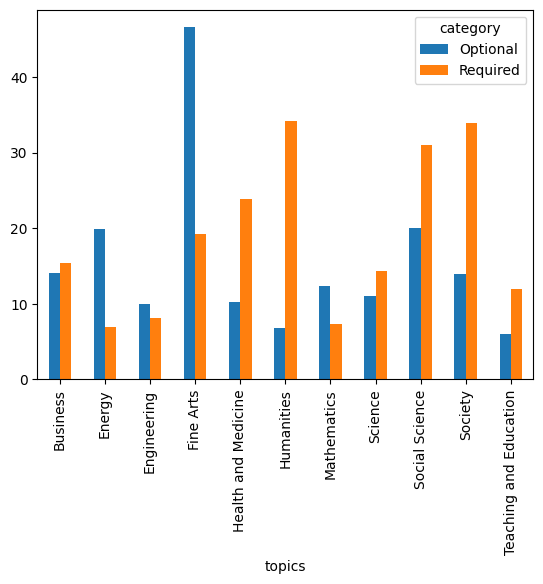

In [47]:
viz_df = product_df[~product_df.topics.str.startswith('-', na=False)].groupby(['topics', 'category']).agg({'title': len, 'course': lambda x: len(set(x.to_list()))}).reset_index()
viz_df['Average Reading per Course'] = round(viz_df['title'] / viz_df['course'], 1)
viz_df[['topics', 'category', 'Average Reading per Course']].pivot(index='topics', columns='category', values='Average Reading per Course').plot(kind='bar')

In [48]:
product_df[~product_df.topics.str.startswith('-', na=False)].groupby(['topics', 'category']).count()['title']

topics                  category
Business                Optional     268
                        Required     569
Energy                  Optional     139
                        Required      69
Engineering             Optional    1098
                        Required    1209
Fine Arts               Optional     233
                        Required     232
Health and Medicine     Optional      31
                        Required     191
Humanities              Optional      82
                        Required     958
Mathematics             Optional     282
                        Required     286
Science                 Optional     636
                        Required    1070
Social Science          Optional    1344
                        Required    3720
Society                 Optional     112
                        Required     476
Teaching and Education  Optional       6
                        Required      24
Name: title, dtype: int64

In [51]:
viz_df[['topics', 'category', 'Average Reading per Course']].pivot(index='topics', columns='category', values='Average Reading per Course')

category,Optional,Required
topics,,
Business,14.1,15.4
Energy,19.9,6.9
Engineering,10.0,8.1
Fine Arts,46.6,19.3
Health and Medicine,10.3,23.9
Humanities,6.8,34.2
Mathematics,12.3,7.3
Science,11.0,14.3
Social Science,20.1,31.0


In [54]:
viz_df.groupby('topics').sum()

title                         13035.0
course                          807.0
Average Reading per Course      377.5
dtype: float64